In [1]:
from scipy.integrate import solve_ivp  #Solve an initial value problem for a system of ODEs
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy
from numpy import linalg as LA

In [2]:
K=201  # n of nodes
x=np.linspace(0,1,K) # from 0 to 1 ,201 nodes

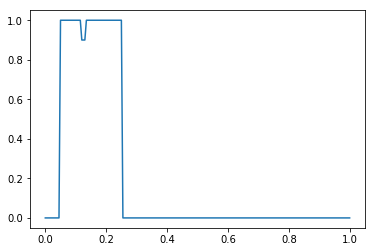

In [52]:
# Initial conditions Slit cyllinder
y0=np.linspace(0,1,K)
y0[(x>0)]=0
y0[(x >= 0.05) & (x <= 0.25)] = 1
y0[(x >= 0.12) & (x <= 0.13)] = 0.9
plt.plot(x,y0)

In [5]:
CFL=0.4 #CFL number
dx=0.005
c=1 # velocity, im not sure about this value!
dt=(dx*CFL)/c
Nt=200   # will use 200 time steps

In [6]:
t=np.arange(0,dt*Nt,dt)
t[:10],t.shape

(array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
        0.018]), (200,))

## Create S matrix

\\begin{align}
\frac{1}{2}
\begin{bmatrix}
    0 & 1 & 0 & \dots  & -1\\
    -1 & 0 & 1 & \dots  & 0 \\
     0 & -1 & 0 &  \dots  & 0 \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & 0 & 0 & \dots  & 0\\
\end{bmatrix}
\end{align}

In [7]:
diagonal = [0]*K      # diagonals
s_upper  = [1]*(K-1)  # upper subdiagonal
s_lower  = [-1]*(K-1) # lower subdiagonal
S = np.diag(diagonal) + np.diag(s_upper, k=1) + np.diag(s_lower, k=-1)
# Periodic Boundary condtion?
S[-1,0] = 1            # first row, last column element = first row (-1) column element
S[0,-1] = -1
S=S/2      

In [8]:
S,S.shape

(array([[ 0. ,  0.5,  0. , ...,  0. ,  0. , -0.5],
        [-0.5,  0. ,  0.5, ...,  0. ,  0. ,  0. ],
        [ 0. , -0.5,  0. , ...,  0. ,  0. ,  0. ],
        ...,
        [ 0. ,  0. ,  0. , ...,  0. ,  0.5,  0. ],
        [ 0. ,  0. ,  0. , ..., -0.5,  0. ,  0.5],
        [ 0.5,  0. ,  0. , ...,  0. , -0.5,  0. ]]), (201, 201))

## Create M matrix

Main diagonal=$\frac{(X_{k+1}-X_{k-1})}{3}$<br>
Lower Subdiagonal=$\frac{(X_{k}-X_{k-1})}{6}$<br>
Upper Subdiagonal=$\frac{(X_{k+1}-X_{k})}{6}$<br>
The rest of the matrix elements are zeros

In [53]:
xM=np.arange(0-dx,1+2*dx,dx)
Mdiag=np.array([(xM[i+1]-xM[i-1])/3 for i in range(1,K+1)])
Msup=np.array([(xM[i+1]-xM[i])/6 for i in range(1,K)])
Msub=np.array([(xM[i]-xM[i-1])/6 for i in range(2,K+1)])
M=np.diag(Mdiag) + np.diag(Msup, k=1) + np.diag(Msub, k=-1)

### With M and S Matrixes the equation can be represented as:

$M\frac{d}{dt}f+cSf
=0$ <br>
$M\frac{d}{dt}f=-cSf
$<br>
$\frac{d}{dt}f=-f*cSM^{-1}
$


##  But we cant invert a matrix M in this case because det(M)=0!

In [10]:
assert round(LA.det(M))!=0,print("Error inverting a matrix!!")
Minv=LA.inv(M)

Error inverting a matrix!!


AssertionError: None

## We will solve this system of ODE using the Runge Kutta 4/5 solver.

In [55]:
# defining F for the solver
B=-CFL*S
def f(t,Y):
    return LA.solve(M,np.dot(B,Y))        # here we solve the equaion instead of inverting the M matrix

In [12]:
# manual check of F
y_test=f(0,np.linspace(0,1,201))
y_test.shape

(201,)

In [13]:
# ‘RK45’ Explicit Runge-Kutta method of order 5(4)
# t_eval Times at which to store the computed solution, must be sorted and lie within t_span.
# t_span Interval of integration (t0, tf). The solver starts with t=t0 and integrates until it reaches t=tf.
r=solve_ivp(f,t_span=(t[0],t[-1]),y0=y0,method='RK45',max_step=0.1,t_eval=t[1:])
r.status # 0 -success

0

In [56]:
Sol_mat=r.y  # Our solutions

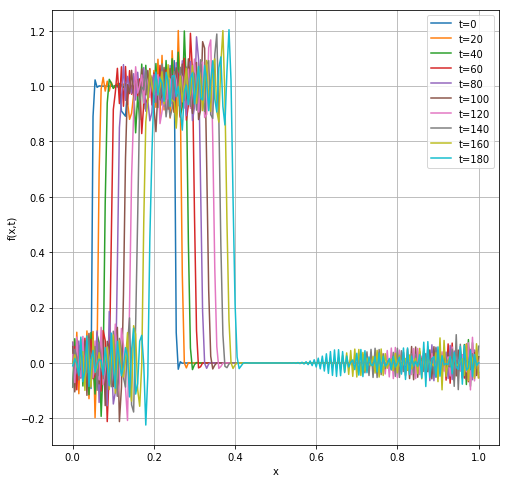

In [51]:
fig=plt.figure(figsize=(8,8))
ax=plt.axes()
for s in range(0,r.y.shape[1],20):
    ax.plot(x,Sol_mat[0:,s],label="t={}".format(s))
    
ax.legend()
ax.grid()
plt.xlabel('x')
plt.ylabel('f(x,t)')
plt.show()   

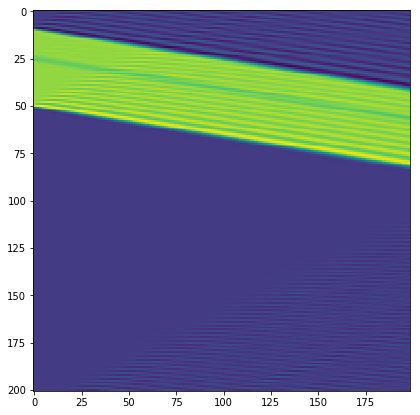

In [50]:
plt.figure(figsize=(7,7))
plt.imshow(Sol_mat[:])
plt.show()